<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr2/blob/main/Sidorov%20Alexander/Final%20version.%20(Profpatolog).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Стажировка. Профпатолог (INSPECTRUM CLINIC)**


    Модели обучения для категориальных данных с удалением строк без заключений в целевом столбце "ЗаключениеМК"
    Целевые категории:


*   Годен
*   Не годен
*   Ограниченно годен

In [ ]:
# @title Загрузка библиотек
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Concatenate,Dense, Activation, Dropout, BatchNormalization, concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Precision, Recall
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from google.colab import drive
import zipfile
import os

In [ ]:
# @title Загрузка датасета
drive.mount('/content/gdrive')
!cp /content/gdrive/MyDrive/Dataset/Dataset.zip	.
z= zipfile.ZipFile('Dataset.zip','r')
!unzip -q -o 'Dataset.zip' -d .
df1 = pd.read_excel(open('/content/Dataset1.xlsx','rb'))
print(df1.shape)
df3 = pd.read_csv('/content/Dataset3.csv', sep=';', header=0, dtype=str)
print(df3.shape)
df = pd.concat([df1, df3])
print(df.shape)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
(1982, 4587)
(32686, 289)
(34668, 4768)


In [ ]:
# @title Объединение датасетов
df = pd.concat([df1, df3])
print(df.shape)
df.head(3)


(34668, 4768)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,ХирургНеИсп2_Диагноз_ЗначениеПредставлениеПредставление,ХирургНеИсп2_МКБ103,ХирургНеИсп3_Диагноз_ЗначениеПредставлениеПредставление,ХирургНеИсп3_МКБ101,ХирургНеИсп3_МКБ102,ХирургНеИсп3_МКБ103,ЭКГНеИсп1_МКБ102,ЭКГНеИсп2_МКБ101,ЭКГНеИсп2_МКБ102,Эндоскопия1_МКБ102
0,7f41ca7e-7dac-11ec-80fc-0cc47aab8067,c91e3407-b81f-11e9-80cf-0cc47aab8067,1976-10-24 00:00:00,Женский,Женский,2022-01-25 00:00:00,Периодический,Периодический,False,23c173a7-30d9-11e7-80d8-708bcd7f83cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2ee1f9ac-83dd-11ec-80fc-0cc47aab8067,1a1a5fea-8b7f-11eb-80e8-0cc47aab8067,1987-11-18 00:00:00,Мужской,Мужской,2022-02-02 00:00:00,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9cbb191e-8e24-11ec-80fe-0cc47aab8067,7fe324e0-fa51-11eb-80f6-0cc47aab8067,1985-09-08 00:00:00,Мужской,Мужской,2022-02-15 00:00:00,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# @title Служебные функции для Исследование датасета
# Вывод количества записей по классам
def print_class(df, column_name, class_list):
  print(class_list)
  for class_name in class_list:
    count = len(df[df[column_name] == class_name])
    print(f'Количество записей для класса {class_name}: {count}')

# Поиск колонок и вывод уникальных значений
def Find_Column(df, name):
  pred_cols = [col for col in df.columns if name in col]
  print(f'Найдено {len(pred_cols)} колонок')
  for column_name in pred_cols:
      print(f'{df.columns.get_loc(column_name)} {column_name}')
      unique_data = df[column_name].unique()
      print(f'   {unique_data[0:10]}')

In [ ]:
# @title Подготовка датасета
# Удаление строк без заключения
print('Datafrme до обработки')
print(df.shape)
class_list =['Годен','ГоденСКоррекциейЗрения','ГоденСКоррекциейСлуха','НуждаетсяВДообследованииИЛечении','ВременноНегоден','ОграниченноГоден','ГоденБезРаботНаВысотах']
mask= df['ЗаключениеМК'].str.contains('|'.join(class_list))>0
df = df[ mask]
print('Datafrme поле удаления пустых заключений')
print(df.shape)
# количество записей по классам
print('Rоличество записей по классам')
print_class(df, 'ЗаключениеМК', class_list)
# Сокращение классов до 3
print('Сокращение классов до 3 классов')
df.loc[df['ЗаключениеМК'] == 'ГоденСКоррекциейЗрения','ЗаключениеМК'] = 'ОграниченноГоден'
df.loc[df['ЗаключениеМК'] == 'ГоденБезРаботНаВысотах','ЗаключениеМК'] = 'ОграниченноГоден'
df.loc[df['ЗаключениеМК'] == 'ГоденСКоррекциейСлуха' ,'ЗаключениеМК'] = 'ОграниченноГоден'
df.loc[df['ЗаключениеМК'] == 'НуждаетсяВДообследованииИЛечении', 'ЗаключениеМК'] = 'ВременноНегоден'
# количество записей по классам
#print_class(df, 'ЗаключениеМК', class_list)
class_list =['Годен','ВременноНегоден','ОграниченноГоден']
print_class(df, 'ЗаключениеМК', class_list)
# Переиндексация df
df = df.reset_index(drop=True)

Datafrme до обработки
(34668, 4768)
Datafrme поле удаления пустых заключений
(20768, 4768)
Rоличество записей по классам
['Годен', 'ГоденСКоррекциейЗрения', 'ГоденСКоррекциейСлуха', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден', 'ГоденБезРаботНаВысотах']
Количество записей для класса Годен: 19416
Количество записей для класса ГоденСКоррекциейЗрения: 1237
Количество записей для класса ГоденСКоррекциейСлуха: 5
Количество записей для класса НуждаетсяВДообследованииИЛечении: 42
Количество записей для класса ВременноНегоден: 9
Количество записей для класса ОграниченноГоден: 6
Количество записей для класса ГоденБезРаботНаВысотах: 53
Сокращение классов до 3 классов
['Годен', 'ВременноНегоден', 'ОграниченноГоден']
Количество записей для класса Годен: 19416
Количество записей для класса ВременноНегоден: 51
Количество записей для класса ОграниченноГоден: 1301


In [ ]:
# @title Исследование датасета (Вывод женских диагнозов)
diagnos_columns = [col for col in df.columns if 'Диагноз_ЗначениеПредставление' in col]
df['diagnos_rows'] = [' '.join([str(row[df.columns.get_loc(col)]) for col in diagnos_columns]) for row in df.values]
df['diagnos_rows'] = [re.sub('\[.*?\]', '', dstr).replace('nan','').replace('_x000D_','').replace('\n','') for dstr in df['diagnos_rows']]
mask =  (df['КлиентПол'] == 'Женский') & ((df['ЗаключениеМК'] == 'ОграниченноГоден') | (df['ЗаключениеМК'] == 'ВременноНегоден'))
display(df[mask][['ЗаключениеМК', 'diagnos_rows']])

,ЗаключениеМК,diagnos_rows
23,ОграниченноГоден,Общий медицинский осмотр МиопияОписание: Мио...
33,ОграниченноГоден,Общий медицинский осмотр Постменопаузный атр...
35,ОграниченноГоден,Общий медицинский осмотр ГиперметропияОписан...
60,ОграниченноГоден,Общий медицинский осмотр МиопияОписание: Мио...
86,ОграниченноГоден,Общий медицинский осмотр АстигматизмОписание...
...,...,...
20603,ОграниченноГоден,...
20606,ОграниченноГоден,...
20715,ОграниченноГоден,...
20717,ОграниченноГоден,...


In [ ]:
# @title Подготовка датасета (Аугментация данных)
mask = (df['ЗаключениеМК'] == 'ОграниченноГоден') | (df['ЗаключениеМК'] == 'ВременноНегоден')
copied_rows = df[mask].copy()
copied_rows['КлиентДатаРождения'] = pd.to_datetime(copied_rows['КлиентДатаРождения']) - pd.DateOffset(years=5)
copied_rows['КлиентПол'] = 'Мужской'
df = pd.concat([df, copied_rows], ignore_index=True)
copied_rows['КлиентПол'] = 'Женский'
df = pd.concat([df, copied_rows], ignore_index=True)
copied_rows['КлиентДатаРождения'] = pd.to_datetime(copied_rows['КлиентДатаРождения']) + pd.DateOffset(years=10)
copied_rows['КлиентПол'] = 'Мужской'
df = pd.concat([df, copied_rows], ignore_index=True)
copied_rows['КлиентПол'] = 'Женский'
df = pd.concat([df, copied_rows], ignore_index=True)
print_class(df, 'ЗаключениеМК', class_list)

['Годен', 'ВременноНегоден', 'ОграниченноГоден']
Количество записей для класса Годен: 19416
Количество записей для класса ВременноНегоден: 255
Количество записей для класса ОграниченноГоден: 6505


In [ ]:
# @title Иследовние датасета (Список колонок для токенизации)
Find_Column( df, 'Диагноз_ЗначениеПредставление')

Найдено 94 колонок
153 ПсихиатрияНаркология1_Диагноз_ЗначениеПредставление
   ['[Z00.0] Общий медицинский осмотр_x000D_\n' nan
 '[R25.1] Тремор неуточненный_x000D_\n'
 '[F06.6] Органическое эмоционально лабильное [астеническое] расстройство_x000D_\n'
 '[F10.2] Психическое и поведенческое расстройство, вызванное употреблением алкоголя. Синдром зависимости_x000D_\n'
 '[F60.3] Эмоционально неустойчивое расстройство личности_x000D_\n'
 '[Z00.4] Общее психиатрическое обследование, не классифицированное в других рубриках_x000D_\n'
 '[F06.7] Легкое когнитивное расстройство_x000D_\nКлассификация: Предварительный, _x000D_\n'
 '[F41.0] Паническое расстройство [эпизодическая пароксизмальная тревожность]_x000D_\nКлассификация: Предварительный, Хроническое, впервые выявленное, Основное заболевание_x000D_\n'
 '[I67.2] Церебральный атеросклероз_x000D_\nКлассификация: Хроническое, ранее выявленное, _x000D_\n']
214 Офтальмология1_Диагноз_ЗначениеПредставление
   ['[Z00.0] Общий медицинский осмотр_x000D

In [ ]:
# @title Служебные функции
def int_to_ohe(arg, class_list):
  # Определение размерности выходного вектора
  num_classes = len(class_list)
  # Поиск верного интервала для входного значения
  for i in range(num_classes - 1):
    if arg < class_list[i]:
      cls = i                       # Интервал найден - назначение класса
      break
    else:                                 # Внимание: for/else
      cls = num_classes - 1             # Интервал не найден - последний класс
  # Возврат в виде one hot encoding-вектора
  return utils.to_categorical(cls, num_classes)

def str_to_multi(arg,class_dict):
  # Определение размерности выходного вектора
  num_classes = len(class_dict)
  # Создание нулевого вектора
  result = np.zeros(num_classes)
  # Поиск значения в словаре и, если найдено,
  # выставление 1. на нужной позиции
  if type(arg) is str:
    if type(class_dict) is list:
      for cls, value in enumerate(class_dict):
        if value == arg:
          result[cls] = 1.
    else:
      for value, cls in class_dict.items():
        if value == arg:
          result[cls] = 1.
  return result

In [ ]:
# @title Токенизация (Диагноз)
diagnos_columns = [col for col in df.columns if 'Диагноз_ЗначениеПредставление' in col]
df['diagnos_rows'] = [' '.join([str(row[df.columns.get_loc(col)]) for col in diagnos_columns]) for row in df.values]
df['diagnos_rows'] = [re.sub('\[.*?\]', '', dstr).replace('nan','').replace('_x000D_','').replace('\n','') for dstr in df['diagnos_rows']]
diagnos_token = Tokenizer(num_words=400, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
diagnos_token.fit_on_texts(df['diagnos_rows'])
df['diagnos_index'] = diagnos_token.texts_to_sequences(df['diagnos_rows'])
df['diagnos_bag'] = diagnos_token.sequences_to_matrix(df['diagnos_index']).tolist()
print(len(diagnos_token.word_index) + 1)
print(diagnos_token.word_index)
print(df.loc[1480,'diagnos_rows'])
print(df.loc[1480,'diagnos_index'])
print(df.loc[1480,'diagnos_bag'])

362
{'unknown': 1, 'общий': 2, 'медицинский': 3, 'осмотр': 4, 'миопия': 5, 'ои': 6, 'ст': 7, 'болезнь': 8, 'без': 9, 'с': 10, 'миопияописание': 11, 'сердца': 12, 'гипертензивная': 13, 'преимущественным': 14, 'поражением': 15, 'застойной': 16, 'сердечной': 17, 'недостаточности': 18, 'астигматизм': 19, 'астигматизмописание': 20, 'гиперметропия': 21, 'кариес': 22, 'сл': 23, 'миопический': 24, 'ср': 25, 'дентина': 26, 'гиперметропияописание': 27, 'хронический': 28, 'обоих': 29, 'сложный': 30, 'глаз': 31, 'ос': 32, '1': 33, 'степени': 34, 'зубной': 35, 'налет': 36, 'смешанный': 37, 'апикальный': 38, 'периодонтит': 39, 'апикальная': 40, 'гранулема': 41, 'слабой': 42, 'од': 43, 'или': 44, 'гастрит': 45, 'и': 46, 'неуточненная': 47, 'поверхностный': 48, 'матки': 49, 'амблиопия': 50, 'неуточненный': 51, 'последствия': 52, 'хроническое': 53, 'выявленное': 54, 'другие': 55, 'старческая': 56, 'начальная': 57, 'средней': 58, 'глаза': 59, 'неуточненное': 60, 'простой': 61, 'катаракта': 62, 'ранее': 

In [ ]:
# @title Токенизация (МКБ)
mkb_columns = [col for col in df.columns if 'МКБ' in col]
df['mkb_rows'] = [' '.join([str(row[df.columns.get_loc(col)]) for col in mkb_columns]) for row in df.values]
df['mkb_rows'] = [re.sub('\[.*?\]', '', dstr).replace('nan','').replace('_x000D_','').replace('\n','') for dstr in df['mkb_rows']]
mkb_token = Tokenizer(num_words=100, filters='!"#$%&()*+,-–—/:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
mkb_token.fit_on_texts(df['mkb_rows'])
df['mkb_index'] = mkb_token.texts_to_sequences(df['mkb_rows'])
df['mkb_bag'] = mkb_token.sequences_to_matrix(df['mkb_index']).tolist()
print(len(mkb_token.word_index) + 1)
print(mkb_token.word_index)
print(df.loc[1988,'mkb_rows'])
print(df.loc[1988,'mkb_index'])
print(df.loc[1988,'mkb_bag'])

354
{'unknown': 1, 'z00.0': 2, 'h52.1': 3, 'i11.9': 4, 'h52.2': 5, 'h52.0': 6, 'k29.3': 7, 'k29.5': 8, 'k29.6': 9, 'd25': 10, 'h90.3': 11, 'h91.1': 12, 'h25.0': 13, 'h53.0': 14, 'd25.9': 15, 'h74.1': 16, 'n60.2': 17, 'k29.8': 18, 'k86.1': 19, 'k26.7': 20, 't94.0': 21, 'r73.9': 22, 'm42.1': 23, 'h90.4': 24, 'h47.2': 25, 'k40.9': 26, 'n83.2': 27, 'l40.0': 28, 'f06.6': 29, 'r25.1': 30, 'g90.8': 31, 'n70.9': 32, 'g90.9': 33, 'f06.8': 34, 'k80.2': 35, 'i67.2': 36, 'h66.1': 37, 't90.4': 38, 'e11.9': 39, 'i25.8': 40, 'f10.3': 41, 'i25.2': 42, 'h50.9': 43, 'i11.0': 44, 'n80.0': 45, 'i83.9': 46, 'i25.9': 47, 'h25': 48, 'e11.8': 49, 'j45.9': 50, 'h50.0': 51, 'h26.9': 52, 'i77.9': 53, 'i72.1': 54, 'z32.1': 55, 'g25.0': 56, 'k29.7': 57, 'h11.0': 58, 'j33.0': 59, 'i49.9': 60, 'e14.9': 61, 'h40.1': 62, 'h27.0': 63, 'k26.9': 64, 'k80.5': 65, 'k20': 66, 'i67.9': 67, 'h53.5': 68, 'h50.1': 69, 'f60.3': 70, 'h52.4': 71, 'd50.9': 72, 'h02.4': 73, 'h01.0': 74, 'k82.9': 75, 'n20.9': 76, 'n86': 77, 'g99.0': 

In [ ]:
# @title Токенизация (Профессия)
df['prof_index']= ' '
df['prof_bag'] = ' '
prof_token = Tokenizer(num_words=600, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
prof_token.fit_on_texts(df['Профессия'].astype(str).replace('nan',''))
df['prof_index'] = prof_token.texts_to_sequences(df['Профессия'].astype(str).replace('nan',''))
df['prof_bag'] = prof_token.sequences_to_matrix(df['prof_index']).tolist()
print(len(prof_token.word_index) + 1)
print(prof_token.word_index)
print(df.loc[1478,'Профессия'])
print(df.loc[1478,'prof_index'])
print(df.loc[1478,'prof_bag'])

1911
{'unknown': 1, 'по': 2, 'инженер': 3, 'водитель': 4, 'разряда': 5, 'и': 6, 'специалист': 7, 'машинист': 8, 'автомобиля': 9, 'ведущий': 10, 'слесарь': 11, 'монтажник': 12, '6': 13, 'оператор': 14, 'категории': 15, '5': 16, 'повар': 17, 'начальник': 18, 'ремонту': 19, 'технологических': 20, 'мастер': 21, 'старший': 22, 'продавец': 23, 'менеджер': 24, 'главный': 25, '4': 26, 'отдела': 27, 'работ': 28, '1': 29, 'трубопроводов': 30, 'электромонтажник': 31, 'скважин': 32, '2': 33, 'электрогазосварщик': 34, 'вышкомонтажник': 35, 'помощник': 36, '3': 37, 'с': 38, 'на': 39, 'администратор': 40, 'сервис': 41, 'работник': 42, 'кассир': 43, 'техник': 44, 'торгового': 45, 'обслуживанию': 46, 'электромонтер': 47, 'зала': 48, 'учитель': 49, 'врач': 50, 'электрооборудования': 51, 'капитального': 52, 'ремонта': 53, 'геофизик': 54, 'крана': 55, 'рабочий': 56, 'установок': 57, 'экспедитор': 58, 'заместитель': 59, 'директор': 60, 'участка': 61, 'конструкций': 62, 'бурению': 63, 'грузчик': 64, 'руково

In [ ]:
# @title Токенизация (Цех)
df['work_index']= ' '
df['work_bag'] = ' '
work_token = Tokenizer(num_words=300, filters='!"#$%&()*+,-–—./:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
work_token.fit_on_texts(df['Цех'].astype(str).replace('nan',''))
df['work_index'] = work_token.texts_to_sequences(df['Цех'].astype(str).replace('nan',''))
df['work_bag'] = work_token.sequences_to_matrix(df['work_index']).tolist()
print(len(work_token.word_index) + 1)
print(work_token.word_index)
print(df.loc[1300,'Цех'])
print(df.loc[1300,'work_index'])
print(df.loc[1300,'work_bag'])

782
{'unknown': 1, 'без': 2, 'отдела': 3, 'отдел': 4, 'уфа': 5, 'и': 6, 'участок': 7, 'цех': 8, 'ооо': 9, 'служба': 10, 'группа': 11, 'по': 12, '025': 13, 'ремонта': 14, 'скважин': 15, 'текущего': 16, 'капитального': 17, '№2': 18, 'центр': 19, 'производственный': 20, 'вс': 21, 'подразделение': 22, 'упнр': 23, 'г': 24, 'межрайонный': 25, 'обособленное': 26, 'то': 27, 'производство': 28, 'инженерно': 29, 'эксплуатации': 30, 'обеспечения': 31, '№1': 32, '«территория': 33, 'еды': 34, '102»': 35, 'ашан': 36, 'сити': 37, 'с': 38, 'технический': 39, 'техносервис': 40, 'коммерцмагазина': 41, 'отделение': 42, 'приволжский': 43, 'филиал': 44, 'фгуп': 45, 'радон': 46, 'благовещенское': 47, 'в': 48, '№': 49, 'сектор': 50, '1': 51, 'логистики': 52, 'администрация': 53, 'детский': 54, 'сад': 55, 'лаборатория': 56, 'проектирования': 57, 'бортового': 58, 'дрс': 59, 'обработке': 60, 'на': 61, 'умный': 62, 'ритейл': 63, 'дмш': 64, 'диагностики': 65, 'гдс': 66, 'бригада': 67, 'питания': 68, 'технологичес

In [ ]:
# @title Классификация ВредныеФакторы
hazard_token = Tokenizer(num_words=300, filters='!"#$%&()*+,-–—/:;<=>?@[\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
hazard_token.fit_on_texts(df['ВредныеФакторы'].astype(str).replace('nan',''))
df['hazard_index'] = hazard_token.texts_to_sequences(df['ВредныеФакторы'].astype(str).replace('nan',''))
df['hazard_bag'] = hazard_token.sequences_to_matrix(df['hazard_index']).tolist()
print(len(hazard_token.word_index) + 1)
print(hazard_token.word_index)
print(df.loc[2800,'ВредныеФакторы'])
print(df.loc[2800,'hazard_index'])
print(df.loc[2800,'hazard_bag'])

184
{'unknown': 1, '5.1': 2, '4.4': 3, '11.1': 4, '23': 5, '6.1': 6, '4.2.5': 7, '18.1': 8, '6.2': 9, '11.4': 10, '9': 11, '4.7': 12, '6': 13, '15': 14, '4.3.2': 15, '1.50': 16, '18.2': 17, '17': 18, '4.3.1': 19, '4.8': 20, '27': 21, '25': 22, '11.3': 23, '1.1': 24, '13': 25, '04.02.2005': 26, '3.1.7': 27, '26': 28, '12': 29, '4.1': 30, '1.39': 31, '18': 32, '1.29.2': 33, '1.30.1': 34, '11': 35, '4.2.1': 36, '1.37.1': 37, '1.14.2': 38, '1.3': 39, '5.2.1': 40, '1.36.1': 41, '22': 42, '4.9': 43, '1.23': 44, '1.8.1.1': 45, '18.янв': 46, '1.34.1': 47, '8': 48, '05.янв': 49, '1.15': 50, '3.1.2': 51, '4.2.3': 52, '3.4': 53, '5.2': 54, '1.29.1': 55, '18.фев': 56, '4.5': 57, '4.2.4': 58, '11.янв': 59, '4.2.2': 60, '4.10': 61, '1.19.1': 62, '3.1.8.2': 63, '1.2': 64, '4.6': 65, '1.8.1.2': 66, '2.4.2': 67, '3.1': 68, '4.2': 69, '1.48': 70, '4.3': 71, '3.1.8.3': 72, '1.17': 73, '1.36': 74, '1.27.1': 75, '3.1.1': 76, '14': 77, '1.18.3': 78, '2.4.3': 79, '1.5': 80, '1.8.2.1': 81, '3.1.8': 82, '24': 

In [ ]:
# @title Классификация Заключения
fit_columns = [col for col in df.columns if 'ГоденНегоден_ЗначениеПредставление' in col]
print(len(fit_columns))
for index, row in df.iterrows():
   f = []
   for col in fit_columns:
    f.append(', '.join(str(x) for x in str_to_multi(row[col],class_list)))
   df.loc[index, 'fit_bag'] = ', '.join(str(x) for x in f)
print(df.loc[6,'fit_bag'])

31
0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


In [ ]:
# @title Классификация возраста
age_class = [18, 23, 28, 33, 38, 43, 48, 53, 58, 63]
df['age_bag'] = ''
for index, row in df.iterrows():
  v = pd.to_datetime(row['ДатаЗавершенияМедосмотра'], errors='coerce').year-pd.to_datetime(row['КлиентДатаРождения'], errors='coerce').year
  df.loc[index, 'age_bag'] = ', '.join(str(x) for x in int_to_ohe(v, age_class))
#  print(row['age_bag'])
print(df.loc[6,'age_bag'])

0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0


In [ ]:
# @title Классификация пола
for index, row in df.iterrows():
  if row['КлиентПол'] == 'Мужской':
    df.loc[index, 'sex_bag'] = '1'
  else:
    df.loc[index, 'sex_bag'] = '0'
print(f"{df.loc[2800,'КлиентПол']} {df.loc[2800,'sex_bag']}")

Мужской 1


In [ ]:
# @title Функции подготовки датасета
def extract_row_data(index, row):
  # Извлечение и преобразование данных
  age = [float(num_str) for num_str in row.loc['age_bag'].split(",")]
  # Пол
  sex = [float(num_str) for num_str in row.loc['sex_bag'].split(",")]
  # Заключения
  fit = [float(num_str) for num_str in row.loc['fit_bag'].split(",")]
  # Токенайзер с диагнозами
  diagnos = row.loc['diagnos_bag']
  # Токенайзер с кодами МКБ
  mkb = row['mkb_bag']
  #Токенайзер профессий
  prof = row['prof_bag']
  #Токенайзер цехов
  work = row['work_bag']
  # Вредность
  hazard = row['hazard_bag']
  x_data1 = np.hstack([age, sex,work])
  x_data2 = np.hstack([fit])
  x_data3 = np.hstack([diagnos, mkb])
  x_data4 = np.hstack([hazard])
  x_data5 = np.hstack([prof])
  y_data =  np.hstack([class_list.index(row.loc['ЗаключениеМК'])])
 # if y_data > 0 and index < 500:
 #   print(f"y_data {y_data} {row.loc['ЗаключениеМК']}")
 #   print(f"x_data1 {x_data1[:30]} ")# {row.loc['diagnos_index']} {row.loc['diagnos_rows']}")
 #   print(f"x_data3 {x_data3[:30]} ")# {row.loc['diagnos_index']} {row.loc['diagnos_rows']}")
 #   print(f"x_data2 {x_data2[:30]} {row.loc['diagnos_index']} {row.loc['diagnos_rows']}")
  return x_data1, x_data2, x_data3, x_data4, x_data5, y_data

# Создание общей выборки
def construct_train_data():
  x_data1 = []
  x_data2 = []
  x_data3 = []
  x_data4 = []
  x_data5 = []
  y_data = []
  num = 0
  for index, row in df.iterrows():
    x1, x2, x3, x4, x5, y = extract_row_data(index, row)
    num +=1
    x_data1.append( x1)
    x_data2.append( x2)
    x_data3.append( x3)
    x_data4.append( x4)
    x_data5.append( x5)
    y_data.append(y)
  return np.array(x_data1),  np.array(x_data2), np.array(x_data3), np.array(x_data4), np.array(x_data5), np.array(y_data)

In [ ]:
# @title Создание датасета
#print(df.shape)
x_data1, x_data2, x_data3, x_data4, x_data5, y_data = construct_train_data()
# Перевод в one hot encoding
y_data = utils.to_categorical(y_data, 3)
print(f' x_data1 {x_data1.shape} \t x_data2 {x_data2.shape} \t x_data3 {x_data3.shape} \t x_data4 {x_data4.shape}\t x_data5 {x_data5.shape} \t y_data {y_data.shape}')
# Разбиение наборов на общую и тестовую выборки
x_all1, x_test1, x_all2, x_test2, x_all3, x_test3, x_all4, x_test4, x_all5, x_test5, y_all, y_test = train_test_split(x_data1, x_data2, x_data3, x_data4, x_data5, y_data,
                                                test_size=0.15, shuffle=True, random_state = 6)
print(f' x_all1 {x_all1.shape} \t x_all2 {x_all2.shape} \t x_all3 {x_all3.shape} \t x_all4 {x_all4.shape} \t x_all5 {x_all5.shape} \t y_all {y_all.shape}')
print(f' x_test1 {x_test1.shape} \t x_test2 {x_test2.shape} \t x_test3 {x_test3.shape} \t x_test4 {x_test4.shape} \t x_test5 {x_test5.shape} \t y_test {y_test.shape}')
# Разбиваем данные на обучающую, валидационную и тестовую выборки для одного вектора
x_train1, x_val1, x_train2, x_val2, x_train3, x_val3, x_train4, x_val4, x_train5, x_val5, y_train, y_val = train_test_split(x_all1, x_all2, x_all3, x_all4, x_all5, y_all,
                                                test_size=0.15, shuffle=True, random_state = 6)
print(f' x_val1 {x_val1.shape} \t x_val2 {x_val2.shape} \t x_val3 {x_val3.shape} \t x_val4 {x_val4.shape} \t x_val5 {x_val5.shape} \t y_val {y_val.shape}')
print(f' x_train1 {x_train1.shape} \t x_train2 {x_train2.shape} \t x_train3 {x_train3.shape} \t x_train4 {x_train4.shape} \t x_train5 {x_train5.shape} \t y_train {y_train.shape}')

 x_data1 (26176, 311) 	 x_data2 (26176, 93) 	 x_data3 (26176, 500) 	 x_data4 (26176, 300)	 x_data5 (26176, 600) 	 y_data (26176, 3)
 x_all1 (22249, 311) 	 x_all2 (22249, 93) 	 x_all3 (22249, 500) 	 x_all4 (22249, 300) 	 x_all5 (22249, 600) 	 y_all (22249, 3)
 x_test1 (3927, 311) 	 x_test2 (3927, 93) 	 x_test3 (3927, 500) 	 x_test4 (3927, 300) 	 x_test5 (3927, 600) 	 y_test (3927, 3)
 x_val1 (3338, 311) 	 x_val2 (3338, 93) 	 x_val3 (3338, 500) 	 x_val4 (3338, 300) 	 x_val5 (3338, 600) 	 y_val (3338, 3)
 x_train1 (18911, 311) 	 x_train2 (18911, 93) 	 x_train3 (18911, 500) 	 x_train4 (18911, 300) 	 x_train5 (18911, 600) 	 y_train (18911, 3)


In [ ]:
# @title Оценка модели на тестовых данных и построение графиков
def evaluate_model(model, x_t, y_t):
    # Оценка точности и потери на тестовых данных
    evaluation = model.evaluate(x_t)
    #loss, accuracy = model.evaluate(x_t)
    loss = evaluation[0]
    accuracy = evaluation[1]
    print("Test Loss: {:.3f}".format(loss))
    print("Test Accuracy: {:.3f}".format(accuracy))

    # Получение прогноза модели на тестовых данных
    y_p = model.predict(x_t)

    # Преобразование one-hot кодирования прогноза в номер класса
    y_p_classes = np.argmax(y_p, axis=1)
    y_t_classes = np.argmax(y_t, axis=1)

    # Построение матрицы ошибок
    from sklearn.metrics import confusion_matrix
    conf_matrix = confusion_matrix(y_t_classes, y_p_classes)

    # Построение графика точности и потери с изменением количества эпох
    epochs = range(1, len(history.history['accuracy']) + 1)
    plt.plot(epochs, history.history['accuracy'], 'bo', label='Средняя абсолютная ошибка на обучающем наборе')
    plt.plot(epochs, history.history['val_accuracy'], 'b', label='Средняя абсолютная ошибка на проверочном наборе')
    plt.title('Training and validation accuracy')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Средняя абсолютная ошибка')
    plt.legend()
    plt.show()

    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Эпоха обучения')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Построение диаграммы матрицы ошибок
    import seaborn as sns
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_list,
                yticklabels=class_list)
    plt.title('Матрица предсказаний')
    plt.xlabel('Предсказано')
    plt.ylabel('Верно')
    plt.show()

# Вывод предсказанных и верных значений
def Print_Predict(model, x_t, y_t):
  y_p = model.predict(x_t)
  y_p_classes = np.argmax(y_p, axis=1)
  y_t_classes = np.argmax(y_t, axis=1)
  correct_preds = (y_p_classes == y_t_classes)
  t = f = 0
  for i in range(len(y_p)):
    if y_p_classes[i] > 0 or y_t_classes[i] > 0:
      print(' Предсказанный класс:', y_p_classes[i], '| Верный класс:', y_t_classes[i], '| Прогноз:', 'ВЕРНО' if (correct_preds[i]) else 'НЕВЕРНО')
      if (correct_preds[i]):
        t+=1
      else:
        f+=1
  accuracy = sum(correct_preds)/len(correct_preds)
  print('Точность на тестовом наборе: {:.2f}% из {} значений. Верно {} Неверно {}'.format(accuracy*100, len(y_p), t, f))

In [ ]:
# @title Объединение векторов для  модели с одним входным вектором
x_train = np.hstack((x_train1, x_train2, x_train3, x_train4, x_train5))
x_val = np.hstack((x_val1, x_val2, x_val3, x_val4, x_val5))
x_test = np.hstack((x_test1, x_test2, x_test3, x_test4, x_test5))

In [ ]:
# @title Создание модели 1 вектор
model = Sequential()
model.add(Dense(units=128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=120, batch_size=128, validation_data=(x_val, y_val))

Epoch 1/120
148/148 [==============================] - 4s 14ms/step - loss: 0.4938 - accuracy: 0.8048 - val_loss: 0.2660 - val_accuracy: 0.8877
Epoch 2/120
148/148 [==============================] - 2s 15ms/step - loss: 0.2477 - accuracy: 0.8958 - val_loss: 0.2291 - val_accuracy: 0.8987
Epoch 3/120
148/148 [==============================] - 2s 11ms/step - loss: 0.2030 - accuracy: 0.9150 - val_loss: 0.1966 - val_accuracy: 0.9134
Epoch 4/120
148/148 [==============================] - 1s 9ms/step - loss: 0.1694 - accuracy: 0.9287 - val_loss: 0.1731 - val_accuracy: 0.9242
Epoch 5/120
148/148 [==============================] - 1s 9ms/step - loss: 0.1456 - accuracy: 0.9404 - val_loss: 0.1629 - val_accuracy: 0.9317
Epoch 6/120
148/148 [==============================] - 1s 9ms/step - loss: 0.1235 - accuracy: 0.9502 - val_loss: 0.1545 - val_accuracy: 0.9380
Epoch 7/120
148/148 [==============================] - 1s 9ms/step - loss: 0.1089 - accuracy: 0.9560 - val_loss: 0.1432 - val_accuracy: 0.9

123/123 [==============================] - 0s 3ms/step
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 

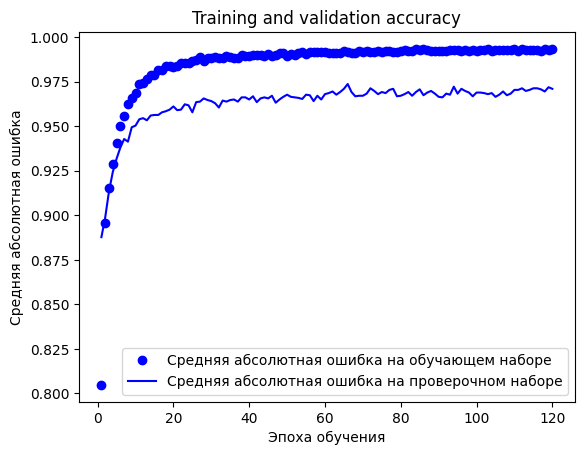

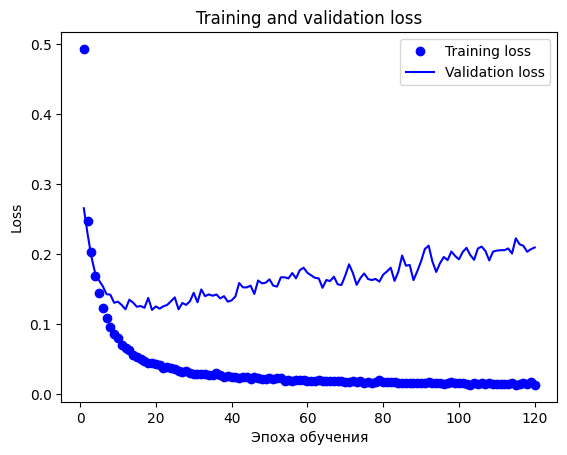

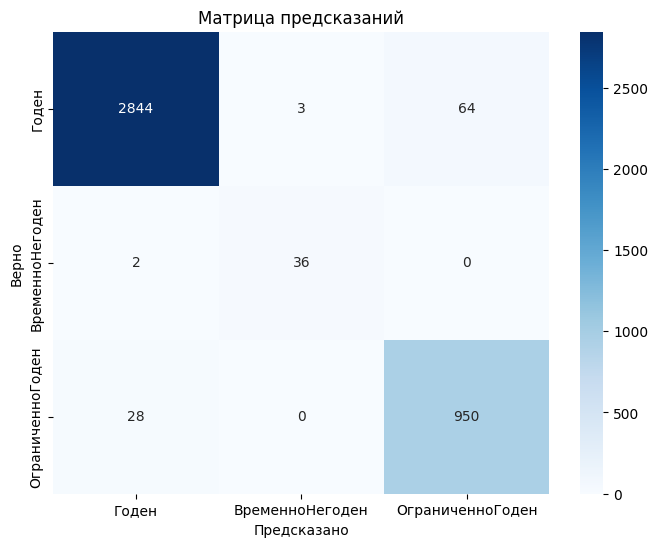

In [ ]:
# @title Вывод результатов обучения с одним входным вектором
Print_Predict(model, x_test, y_test)
evaluate_model(model, x_test, y_test)

In [ ]:
# @title Создание модели с 5 векторами
input1 = Input((x_train1.shape[1],))
input2 = Input((x_train2.shape[1],))
input3 = Input((x_train3.shape[1],))
input4 = Input((x_train4.shape[1],))
input5 = Input((x_train5.shape[1],))

# Определение скрытых слоев для каждого входного слоя
lay1 = Dense(8, activation='relu')(input1)
lay1 = Dropout(0.25) (lay1)

lay2 = Dense(8, activation='relu')(input2)
lay2 = Dropout(0.25) (lay2)

lay3 = Dense(32, activation='relu')(input3)
lay3 = Dropout(0.25) (lay3)
lay3 = Dense(16, activation='relu')(lay3)
lay3 = Dropout(0.25) (lay3)

lay4 = Dense(8, activation='relu')(input4)
lay4 = Dropout(0.25) (lay4)

lay5 = Dense(8, activation='relu')(input5)
lay5 = Dropout(0.25) (lay5)

merged = concatenate([lay1, lay2, lay3, lay4, lay5])
output = Dense(3, activation='softmax')(merged)

model = Model((input1, input2, input3, input4, input5), output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit([x_train1, x_train2, x_train3, x_train4, x_train5], y_train, validation_data=([x_val1, x_val2, x_val3, x_val4, x_val5], y_val), epochs=150, batch_size=32)

Epoch 1/150
591/591 [==============================] - 4s 4ms/step - loss: 0.4340 - accuracy: 0.8298 - val_loss: 0.2829 - val_accuracy: 0.8829
Epoch 2/150
591/591 [==============================] - 3s 4ms/step - loss: 0.2737 - accuracy: 0.8837 - val_loss: 0.2545 - val_accuracy: 0.8901
Epoch 3/150
591/591 [==============================] - 3s 5ms/step - loss: 0.2408 - accuracy: 0.8955 - val_loss: 0.2388 - val_accuracy: 0.8936
Epoch 4/150
591/591 [==============================] - 2s 3ms/step - loss: 0.2236 - accuracy: 0.9034 - val_loss: 0.2298 - val_accuracy: 0.8966
Epoch 5/150
591/591 [==============================] - 2s 3ms/step - loss: 0.2128 - accuracy: 0.9089 - val_loss: 0.2225 - val_accuracy: 0.8990
Epoch 6/150
591/591 [==============================] - 2s 3ms/step - loss: 0.2055 - accuracy: 0.9115 - val_loss: 0.2175 - val_accuracy: 0.9044
Epoch 7/150
591/591 [==============================] - 2s 3ms/step - loss: 0.1968 - accuracy: 0.9151 - val_loss: 0.2146 - val_accuracy: 0.9059

123/123 [==============================] - 0s 2ms/step
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 0 | Верный класс: 2 | Прогноз: НЕВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 0 | Верный класс: 2 | Прогноз: НЕВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 1 | Верный класс: 1 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕРНО
 Предсказанный класс: 2 | Верный класс: 2 | Прогноз: ВЕР

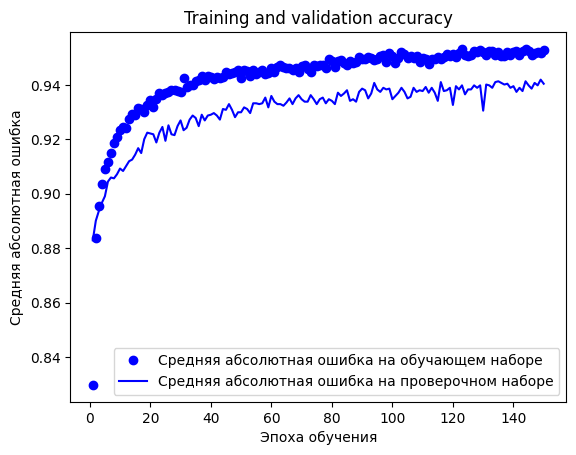

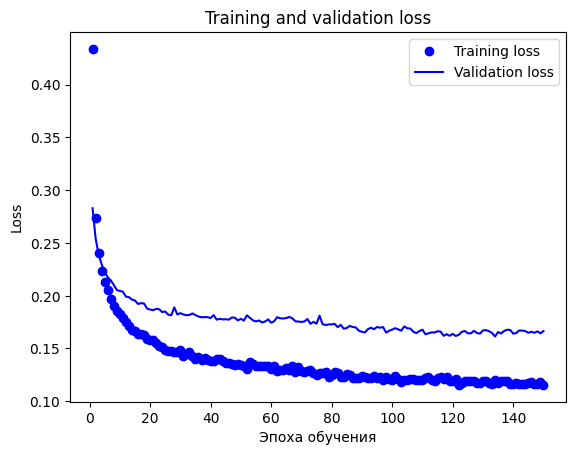

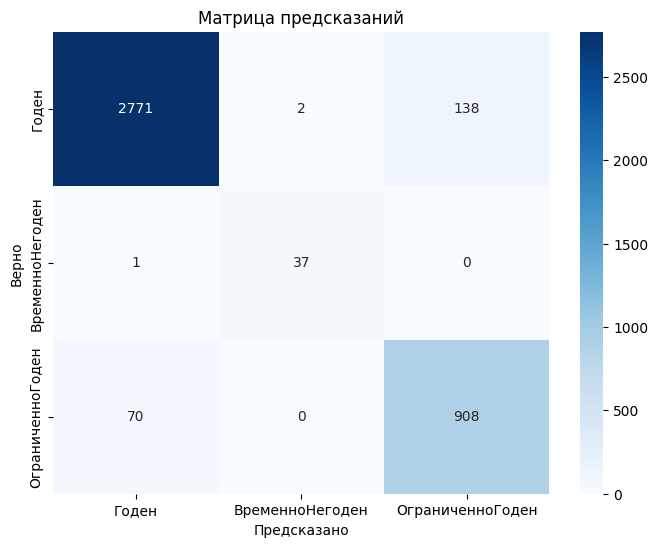

In [ ]:
# @title Вывод результатов обучения с 5 векторами
Print_Predict( model, [x_test1, x_test2, x_test3, x_test4, x_test5], y_test)
evaluate_model(model, [x_test1, x_test2, x_test3, x_test4, x_test5], y_test)